In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

plt.style.use('ggplot')

SYMBOLS = ["SPY", "AAPL", "NVDA", "MSFT", "IBM", "DIS", "HOOD"]
START_DATE = "2013-01-01"
INITIAL_CAPITAL = 1000

In [2]:
def get_data(symbols, start_date):
    data_store = {}
    for sym in symbols:
        try:
            df = yf.download(sym, start=start_date, progress=False)
            
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            
            if not df.empty:
                df = df.dropna()
                data_store[sym] = df
        except Exception:
            pass
            
    return data_store

stock_data = get_data(SYMBOLS, START_DATE)

C:\Users\Hrichik\AppData\Local\Temp\ipykernel_10576\1723736132.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=start_date, progress=False)
C:\Users\Hrichik\AppData\Local\Temp\ipykernel_10576\1723736132.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=start_date, progress=False)
C:\Users\Hrichik\AppData\Local\Temp\ipykernel_10576\1723736132.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=start_date, progress=False)
C:\Users\Hrichik\AppData\Local\Temp\ipykernel_10576\1723736132.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=start_date, progress=False)
C:\Users\Hrichik\AppData\Local\Temp\ipykernel_10576\1723736132.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, start=sta

In [3]:
def prepare_signals(df):
    data = df.copy()
    
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['VolSMA20'] = data['Volume'].rolling(window=20).mean()
    
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
    
    trend_up = data['SMA20'] > data['SMA50']
    
    macd_cross_up = (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1))
    
    vol_strong = data['Volume'] > data['VolSMA20']
    
    data['Entry_Signal'] = trend_up & macd_cross_up & vol_strong
    
    data['Exit_Signal'] = data['SMA20'] < data['SMA50']
    
    return data.dropna()

In [4]:
def run_backtest(df):
    cash = INITIAL_CAPITAL
    shares = 0
    in_position = False
    
    equity_curve = []
    trade_log = []
    
    initial_price = df['Close'].iloc[0]
    bh_shares = INITIAL_CAPITAL / initial_price
    df['BuyHold_Equity'] = df['Close'] * bh_shares
    
    for i in range(len(df)):
        price = df['Close'].iloc[i]
        date = df.index[i]
        
        if not in_position and df['Entry_Signal'].iloc[i]:
            shares = cash / price
            cash = 0
            in_position = True
            trade_log.append({'Type': 'Buy', 'Date': date, 'Price': price})
            
        elif in_position and df['Exit_Signal'].iloc[i]:
            cash = shares * price
            shares = 0
            in_position = False
            trade_log.append({'Type': 'Sell', 'Date': date, 'Price': price})
        
        current_val = cash + (shares * price)
        equity_curve.append(current_val)
        
    df['Strategy_Equity'] = equity_curve
    return df, pd.DataFrame(trade_log)

In [17]:
def calculate_metrics(df, trades):
    # Standard calculations
    df['Daily_Ret'] = df['Strategy_Equity'].pct_change()
    final_equity = df['Strategy_Equity'].iloc[-1]
    total_return = (final_equity - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    
    # Sharpe
    mean_ret = df['Daily_Ret'].mean()
    std_ret = df['Daily_Ret'].std()
    sharpe = (mean_ret / std_ret) * (252**0.5) if std_ret != 0 else 0
    
    # Max Drawdown (Depth)
    cumulative_max = df['Strategy_Equity'].cummax()
    drawdown = (df['Strategy_Equity'] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min() * 100
    
    # --- NEW: Max Drawdown Duration (Time Underwater) ---
    # 1. Identify days where we are below the peak
    is_underwater = df['Strategy_Equity'] < cumulative_max
    
    # 2. Count consecutive days in drawdown
    # (This magic grouping counts consecutive 'True' blocks)
    drawdown_periods = is_underwater.groupby((is_underwater != is_underwater.shift()).cumsum()).cumsum()
    
    # 3. Find the longest period
    max_duration_days = drawdown_periods.max()
    
    # Win Rate
    num_trades = len(trades) // 2
    wins = 0
    if num_trades > 0:
        for i in range(0, len(trades)-1, 2):
            if trades.iloc[i+1]['Price'] > trades.iloc[i]['Price']:
                wins += 1
        win_rate = (wins / num_trades) * 100
    else:
        win_rate = 0
        
    return {
        "Total Return (%)": round(total_return, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Max Drawdown (%)": round(max_drawdown, 2),
        "Max Duration (Days)": int(max_duration_days), # <--- New Metric
        "Num Trades": num_trades,
        "Win Rate (%)": round(win_rate, 2)
    }

In [12]:
def plot_results(symbol, df, trades):
    # Use a slightly larger figure for better PDF quality
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11.69, 8.27), gridspec_kw={'height_ratios': [2, 1]})
    
    # --- Top Chart: Price & Signals ---
    ax1.plot(df.index, df['Close'], label='Price', color='black', alpha=0.6, linewidth=1)
    ax1.plot(df.index, df['SMA20'], label='SMA20', color='blue', alpha=0.3, linewidth=1)
    ax1.plot(df.index, df['SMA50'], label='SMA50', color='orange', alpha=0.3, linewidth=1)
    
    # Add Buy/Sell Markers
    if not trades.empty:
        buys = trades[trades['Type'] == 'Buy']
        sells = trades[trades['Type'] == 'Sell']
        ax1.scatter(buys['Date'], buys['Price'], marker='^', color='green', s=120, label='Buy Signal', zorder=5)
        ax1.scatter(sells['Date'], sells['Price'], marker='v', color='red', s=120, label='Sell Signal', zorder=5)
    
    ax1.set_title(f"{symbol} - Trading Signals & Price Action", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Price ($)")
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # --- Bottom Chart: Equity Curve ---
    ax2.plot(df.index, df['Strategy_Equity'], label='Strategy', color='green', linewidth=2)
    ax2.plot(df.index, df['BuyHold_Equity'], label='Buy & Hold (Benchmark)', color='gray', linestyle='--', linewidth=1.5)
    
    ax2.set_title(f"Equity Curve ($1,000 Initial)", fontsize=12)
    ax2.set_ylabel("Portfolio Value ($)")
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Log scale option (good for long term)
    # ax1.set_yscale('log')
    # ax2.set_yscale('log')
    
    plt.tight_layout()
    
    # 1. Save PNG High Res
    png_filename = f"{symbol}_chart.png"
    plt.savefig(png_filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved image: {png_filename}")
    
    # 2. Show in Notebook
    plt.show() 
    
    # 3. Return Figure for PDF
    return fig

Starting Analysis & Report Generation...

--- Processing SPY ---
✓ Saved image: SPY_chart.png


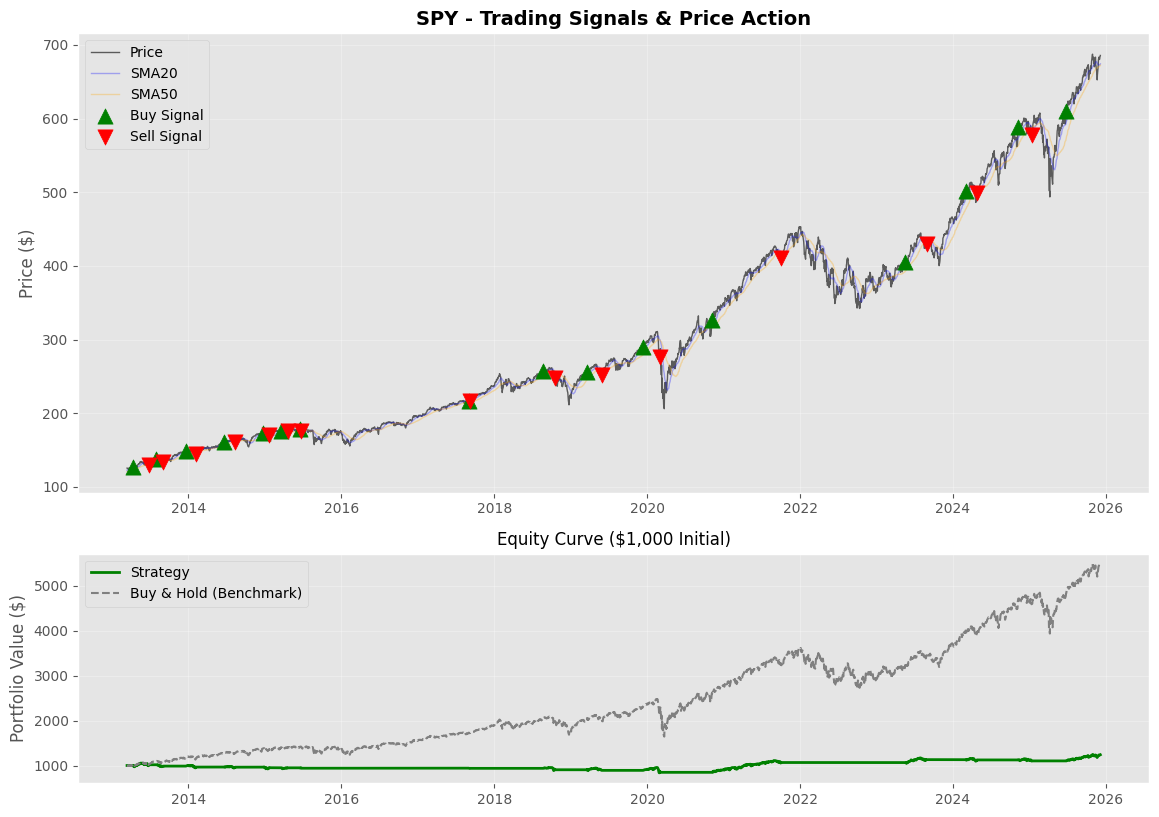

--- Processing AAPL ---
✓ Saved image: AAPL_chart.png


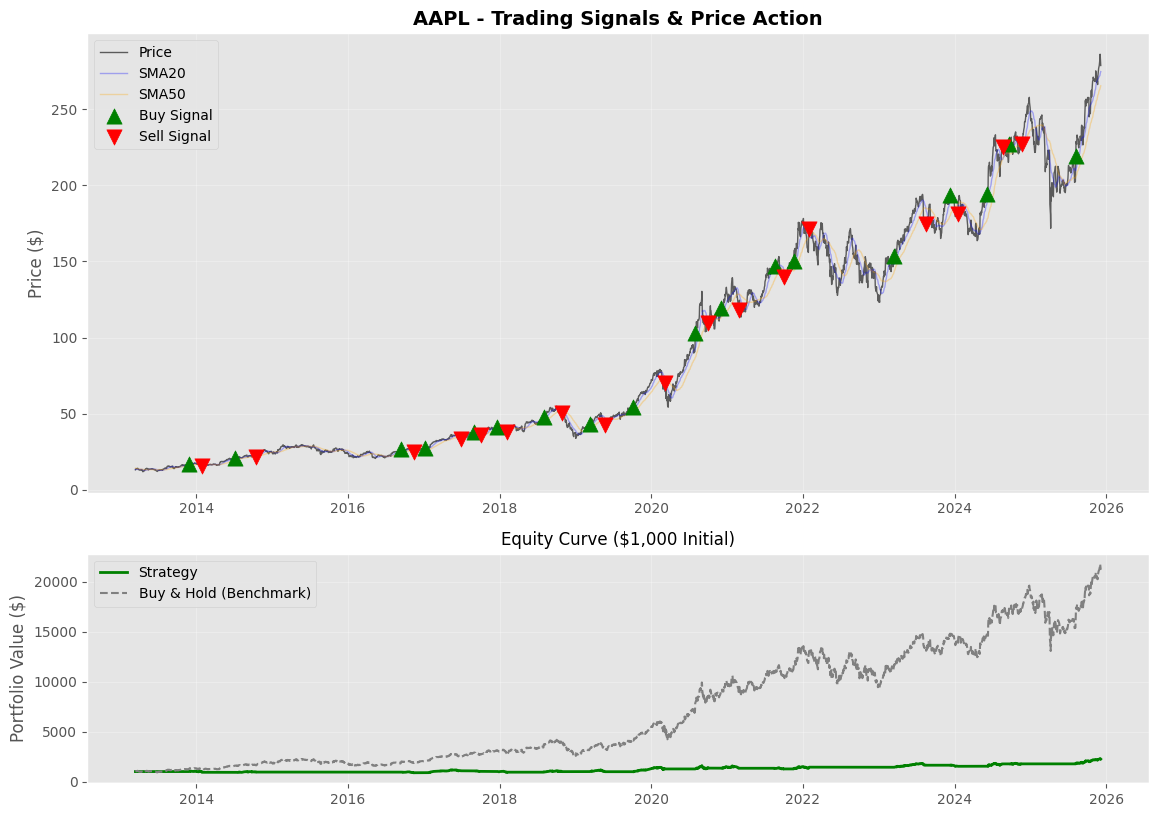

--- Processing NVDA ---
✓ Saved image: NVDA_chart.png


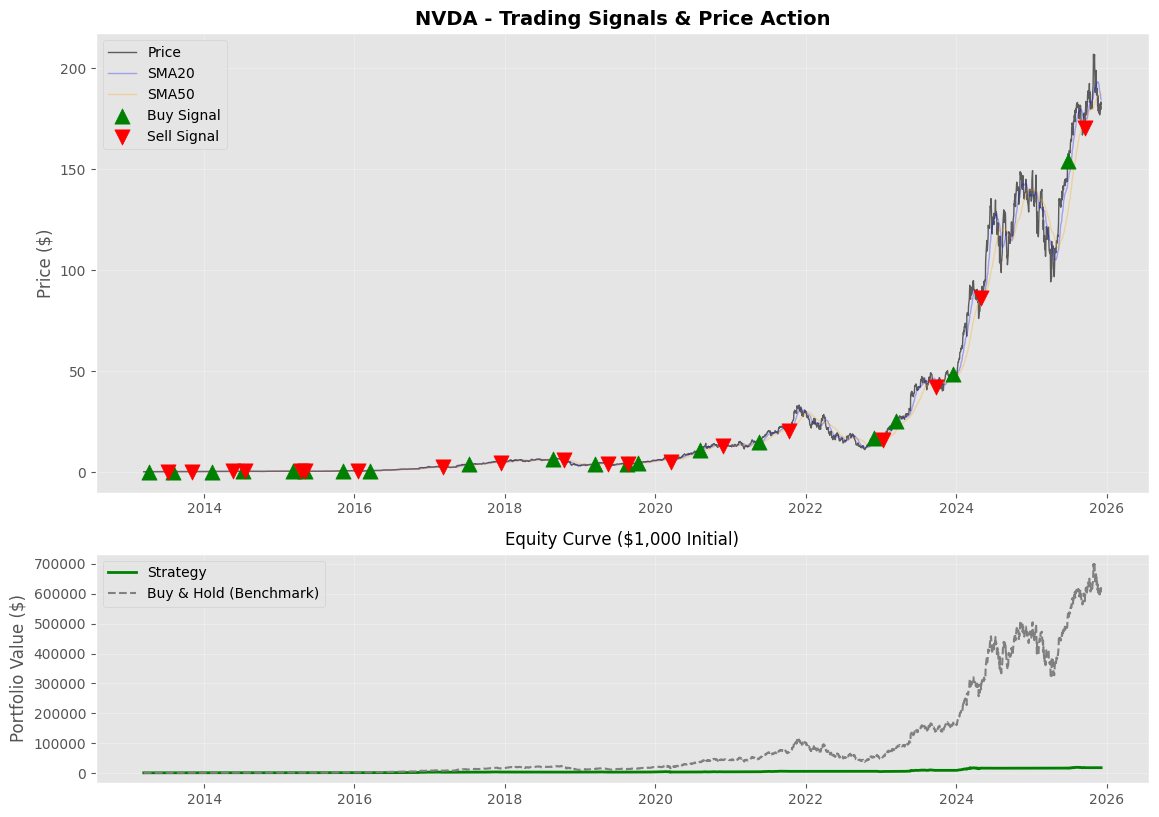

--- Processing MSFT ---
✓ Saved image: MSFT_chart.png


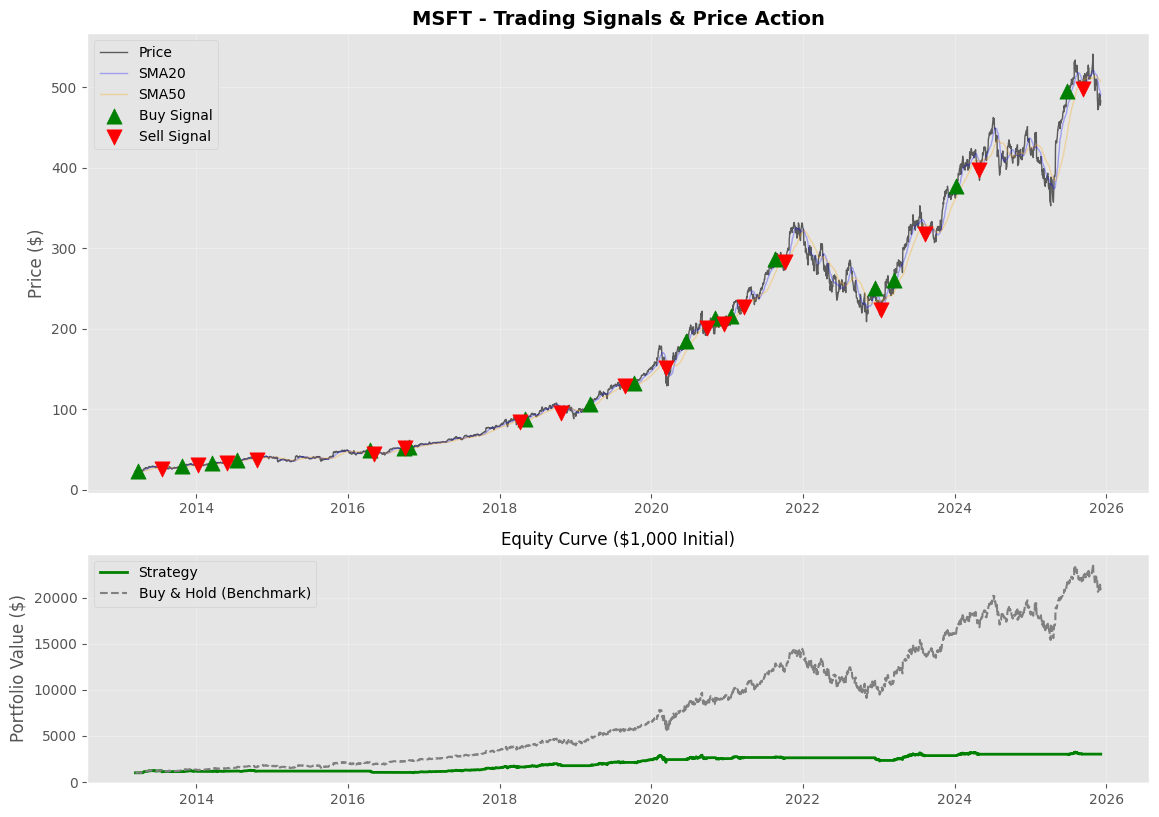

--- Processing IBM ---
✓ Saved image: IBM_chart.png


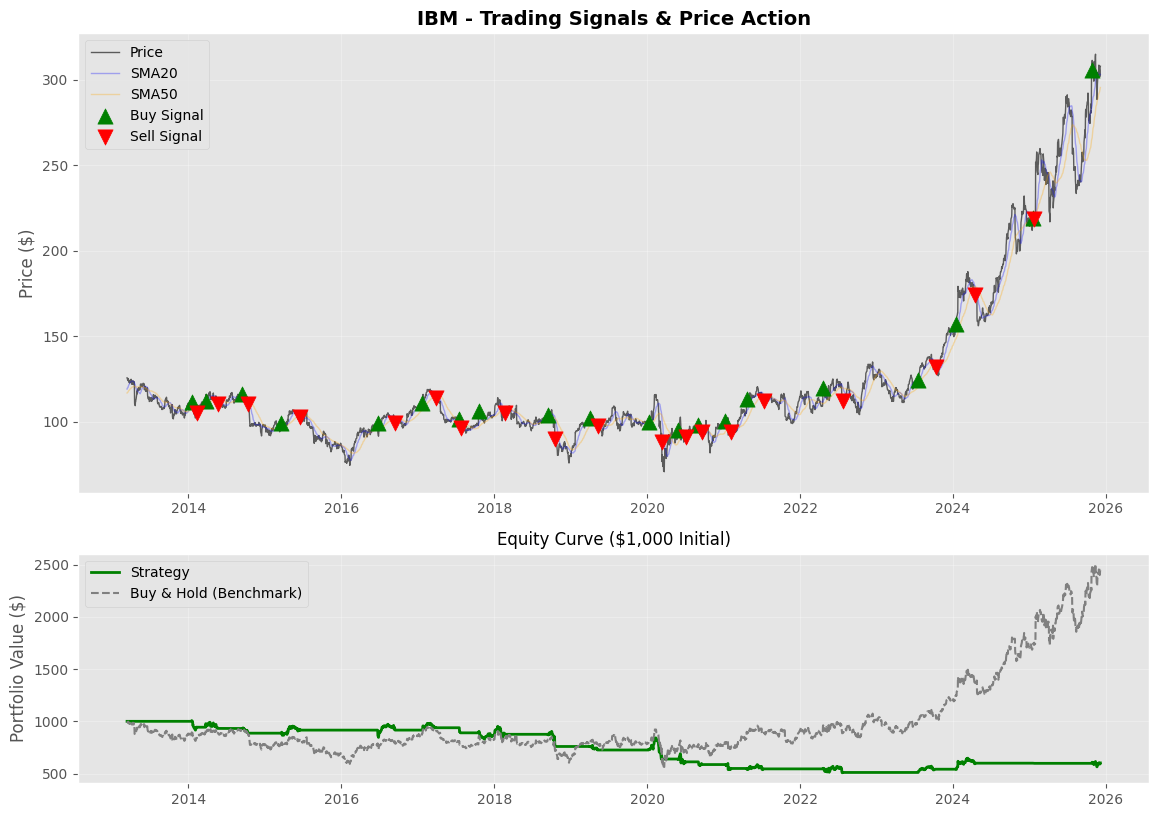

--- Processing DIS ---
✓ Saved image: DIS_chart.png


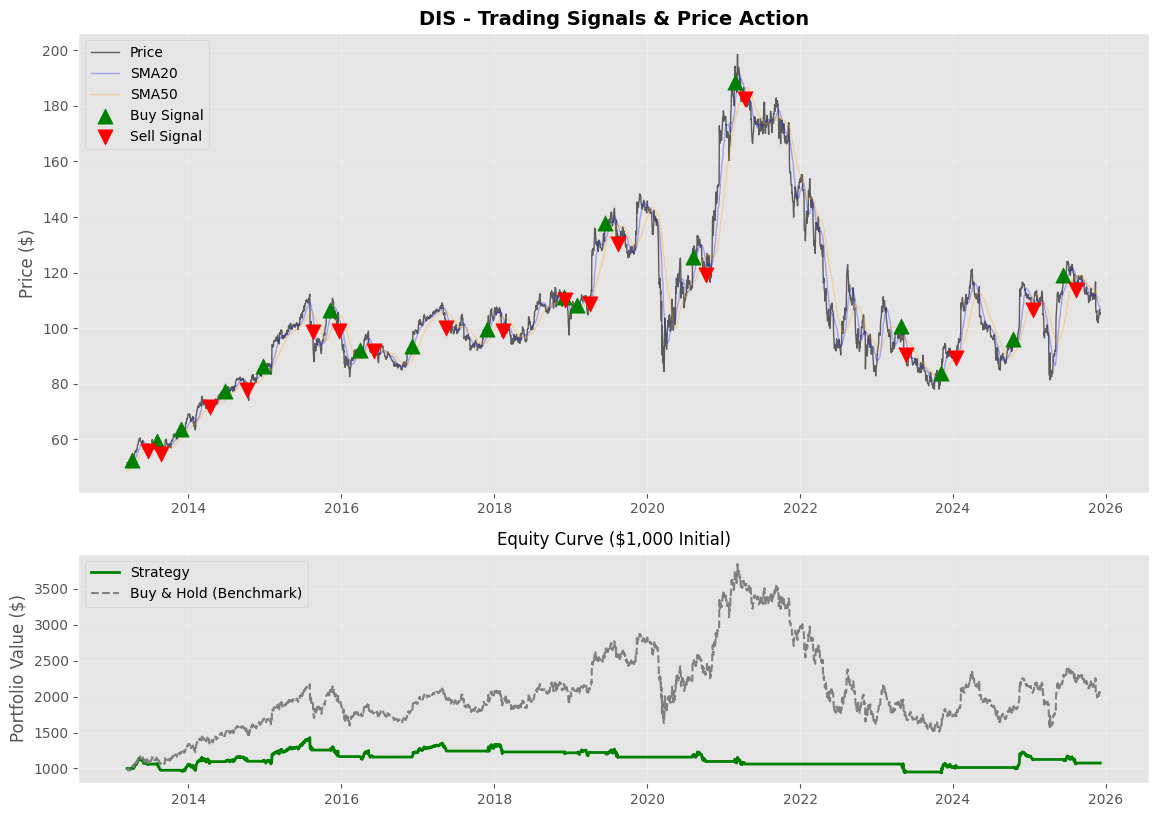

--- Processing HOOD ---
✓ Saved image: HOOD_chart.png


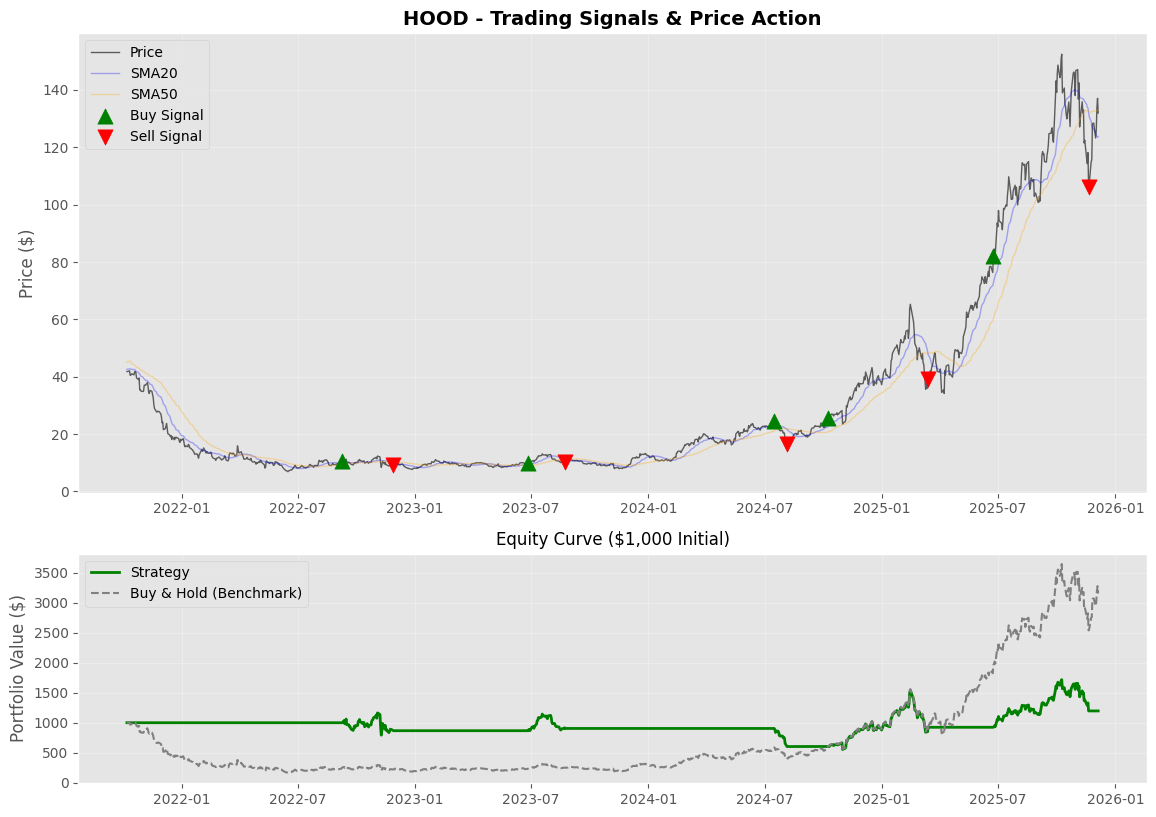

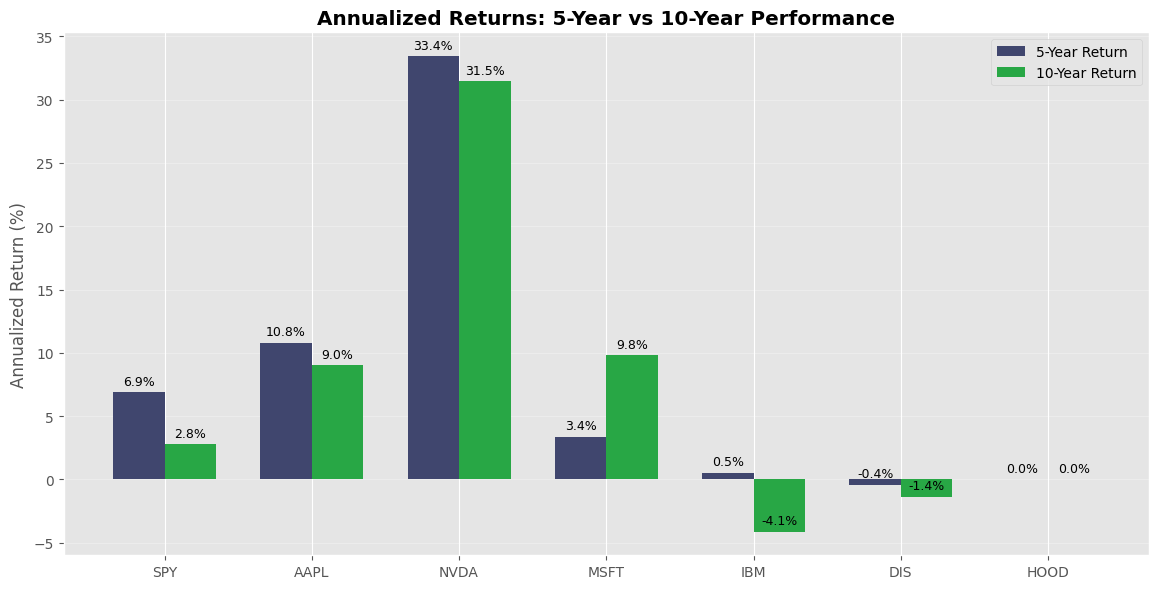


✓ PDF Report Generated: Final_Report.pdf


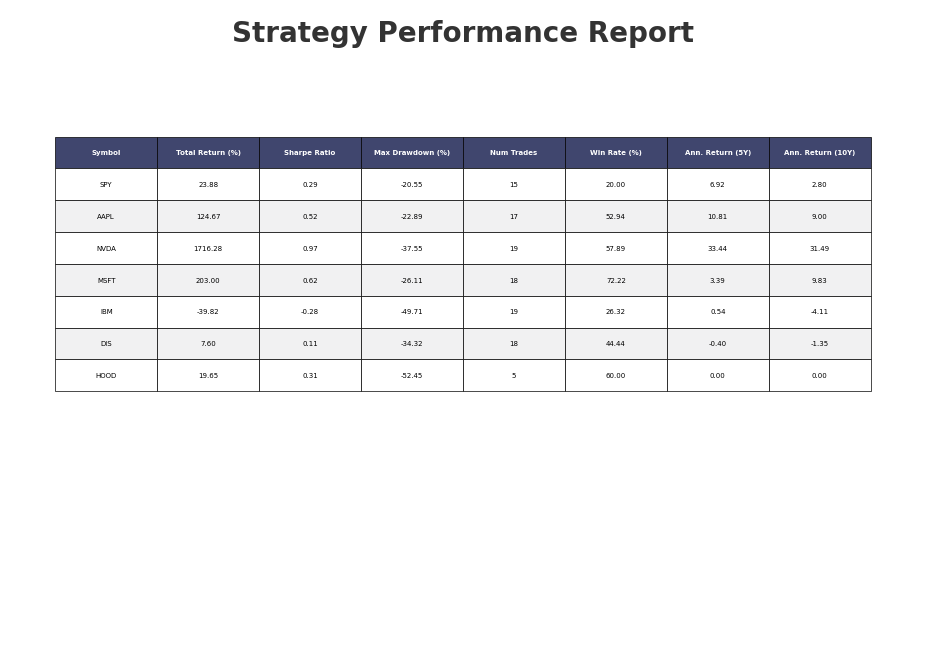

In [15]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

pdf_filename = "Final_Report.pdf"
figures_for_pdf = []

# Storage for the Summary Bar Chart
summary_metrics = []

print(f"Starting Analysis & Report Generation...\n")

# --- Helper: Calculate Annualized Return for a Window ---
def get_annualized_return(equity_curve, years):
    if len(equity_curve) < 252 * years:
        return 0.0
    # Formula: (End_Value / Start_Value) ^ (1/Years) - 1
    start_val = equity_curve.iloc[-(252 * years)]
    end_val = equity_curve.iloc[-1]
    return ((end_val / start_val) ** (1 / years)) - 1

# --- 1. Run Analysis Loop ---
for symbol in SYMBOLS:
    if symbol not in stock_data:
        continue
        
    print(f"--- Processing {symbol} ---")
    
    # Apply Strategy
    df = prepare_signals(stock_data[symbol])
    df, trades = run_backtest(df)
    
    # Generate & Save Price/Equity Chart
    fig = plot_results(symbol, df, trades)
    figures_for_pdf.append(fig)
    
    # --- Calculate 5Y and 10Y Returns for Bar Charts ---
    ann_ret_5y = get_annualized_return(df['Strategy_Equity'], 5) * 100
    ann_ret_10y = get_annualized_return(df['Strategy_Equity'], 10) * 100
    
    # Store for Summary Table & Bar Chart
    stats = calculate_metrics(df, trades) # Overall stats
    stats['Symbol'] = symbol
    stats['Ann. Return (5Y)'] = ann_ret_5y
    stats['Ann. Return (10Y)'] = ann_ret_10y
    summary_metrics.append(stats)

# --- 2. Create "Bar Charts of Annualized Returns" (Requirement 5.3) ---
summary_df = pd.DataFrame(summary_metrics).set_index('Symbol')

fig_bar, ax_bar = plt.subplots(figsize=(11.69, 6))
x = np.arange(len(summary_df))
width = 0.35

bars1 = ax_bar.bar(x - width/2, summary_df['Ann. Return (5Y)'], width, label='5-Year Return', color='#40466e')
bars2 = ax_bar.bar(x + width/2, summary_df['Ann. Return (10Y)'], width, label='10-Year Return', color='#28a745')

ax_bar.set_ylabel('Annualized Return (%)')
ax_bar.set_title('Annualized Returns: 5-Year vs 10-Year Performance', fontweight='bold')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(summary_df.index)
ax_bar.legend()
ax_bar.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax_bar.annotate(f'{height:.1f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show() # Show in notebook
figures_for_pdf.insert(0, fig_bar) # Add to PDF start

# --- 3. Create Styled Table for PDF ---
# Format numbers for display
display_df = summary_df.copy()
cols_to_format = ['Total Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Win Rate (%)', 'Ann. Return (5Y)', 'Ann. Return (10Y)']
for col in cols_to_format:
    if col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

# Prepare Table Data
display_df_final = display_df.reset_index()
table_data = [display_df_final.columns.tolist()] + display_df_final.values.tolist()

fig_table, ax_t = plt.subplots(figsize=(11.69, 8.27))
ax_t.axis('off')
ax_t.text(0.5, 0.95, "Strategy Performance Report", ha='center', fontsize=20, fontweight='bold', color='#333333')

# Draw Table
table = ax_t.table(cellText=table_data, loc='center', cellLoc='center', bbox=[0.05, 0.4, 0.9, 0.4])

# Style Table
header_color = '#40466e'
row_colors = ['#f1f1f2', 'w']
for (row, col), cell in table.get_celld().items():
    cell.set_height(0.08)
    cell.set_fontsize(10)
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(row_colors[row % 2])

figures_for_pdf.insert(0, fig_table) # Table goes first

# --- 4. Save Final PDF ---
with PdfPages(pdf_filename) as pdf:
    for fig in figures_for_pdf:
        pdf.savefig(fig)

print(f"\n✓ PDF Report Generated: {pdf_filename}")

Running Optimization for SPY (this might take a moment)...


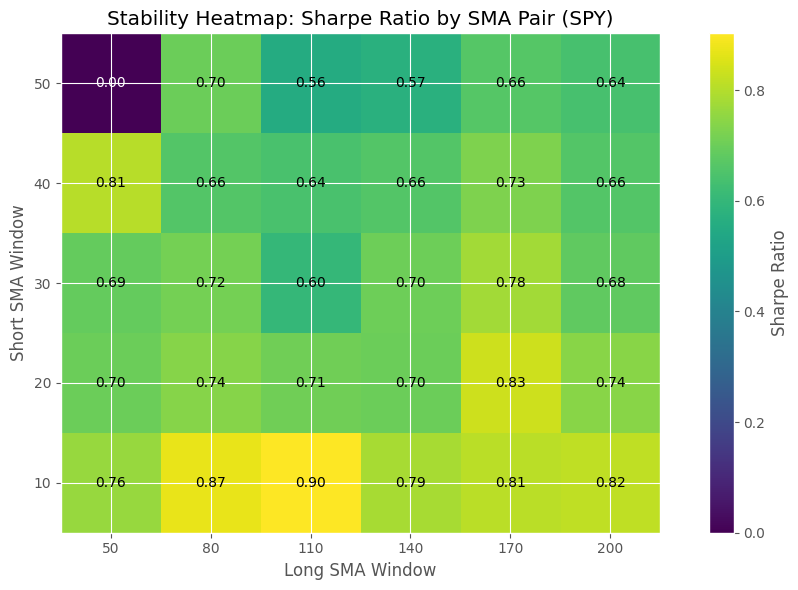

In [16]:
def optimize_parameters(symbol, data):
    # Ranges to test
    short_windows = range(10, 60, 10) # 10, 20, 30...
    long_windows = range(50, 210, 30) # 50, 80, 110...
    
    results = np.zeros((len(short_windows), len(long_windows)))
    
    print(f"Running Optimization for {symbol} (this might take a moment)...")
    
    for i, s_window in enumerate(short_windows):
        for j, l_window in enumerate(long_windows):
            if s_window >= l_window: 
                results[i, j] = 0 # Invalid
                continue
                
            # Quick separate logic test
            temp_df = data.copy()
            temp_df['SMA_S'] = temp_df['Close'].rolling(s_window).mean()
            temp_df['SMA_L'] = temp_df['Close'].rolling(l_window).mean()
            
            # Simple Trend Logic only for speed
            temp_df['Signal'] = np.where(temp_df['SMA_S'] > temp_df['SMA_L'], 1, 0)
            temp_df['Daily_Ret'] = temp_df['Close'].pct_change() * temp_df['Signal'].shift(1)
            
            # Calculate Annualized Sharpe
            mean_ret = temp_df['Daily_Ret'].mean()
            std_ret = temp_df['Daily_Ret'].std()
            sharpe = (mean_ret / std_ret) * (252**0.5) if std_ret != 0 else 0
            results[i, j] = sharpe
            
    # Plot Heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    cax = ax.imshow(results, cmap='viridis', interpolation='nearest', origin='lower')
    
    # Labels
    ax.set_xticks(np.arange(len(long_windows)))
    ax.set_yticks(np.arange(len(short_windows)))
    ax.set_xticklabels(long_windows)
    ax.set_yticklabels(short_windows)
    
    ax.set_xlabel("Long SMA Window")
    ax.set_ylabel("Short SMA Window")
    ax.set_title(f"Stability Heatmap: Sharpe Ratio by SMA Pair ({symbol})")
    
    # Add Colorbar
    cbar = fig.colorbar(cax)
    cbar.set_label("Sharpe Ratio")
    
    # Add text annotations
    for i in range(len(short_windows)):
        for j in range(len(long_windows)):
            text = ax.text(j, i, f"{results[i, j]:.2f}",
                           ha="center", va="center", color="w" if results[i,j] < results.max()/2 else "black")
    
    plt.tight_layout()
    plt.show()

# Run it on SPY or AAPL to demonstrate
if "SPY" in stock_data:
    optimize_parameters("SPY", stock_data["SPY"])